In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb as db
import pandas as pd
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 2000)
# pd.set_option('display.float_format', '{:20,.2f}'.format)
# pd.set_option('display.max_colwidth', None)

C:\Users\AshishJakkam\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Python and SQL - Workflow Analysis


In [2]:
df_StpFcEntries = pd.read_excel('Tech_Datasets2024\StpFcEntries.xlsx')
df_contractPaths = pd.read_excel('Tech_Datasets2024\contractPaths.xlsx')
df_WorkflowTaskInfo = pd.read_excel('Tech_Datasets2024\WorkflowTaskInfo.xlsx')

In [3]:
df_WorkflowTaskInfo.head()

,time_stamp_date,time_stamp_time,status_taken,status_date,status_time,reference_id,body_count,code,description,workflow_id,mode_timeout,category_code,type_code,flow_code,resend,mw_sheet_id,group_id,subprocess_id,xml_ra,xml_lu,xml_lz,xml,reference_id-2,body_reference_id,code-2,input_output,filter_code,lost_data,datasource_code,system_error,body_document_id
0,2012-08-07,1970-01-01 15:06:25,N,2012-08-07,1970-01-01 15:06:25,8586,1,P_COM_FInit-A,P_COM_FInit-A,829,0,Distribution,MX_Completion,META_MX_COM_P,N,1012,0,0,0,390,0,binary data,8586,0,Input,I,8687,N,DIST_ENTRY_SPACE,N,7034
1,2012-08-07,1970-01-01 15:06:25,N,2012-08-07,1970-01-01 15:06:25,8586,1,P_COM_FInit-A,P_COM_FInit-A,829,0,Distribution,MX_Completion,META_MX_COM_P,N,1012,0,0,0,390,0,binary data,8586,1,Output,O,8688,N,DIST_ENTRY_SPACE,N,7035
2,2012-08-07,1970-01-01 15:07:17,N,2012-08-07,1970-01-01 15:07:17,8587,1,P_FXMM_FInit-A_2,P_FXMM_FInit-A_2,829,0,Distribution,MX_Completion,META_MX_CORE_P,N,1113,0,0,0,390,0,binary data,8587,0,Input,I,8689,N,DIST_ENTRY_SPACE,N,7036
3,2012-08-07,1970-01-01 15:07:17,N,2012-08-07,1970-01-01 15:07:17,8587,1,P_FXMM_FInit-A_2,P_FXMM_FInit-A_2,829,0,Distribution,MX_Completion,META_MX_CORE_P,N,1113,0,0,0,390,0,binary data,8587,1,Output,O,8690,N,DIST_ENTRY_SPACE,N,7037
4,2012-08-07,1970-01-01 15:08:03,N,2012-08-07,1970-01-01 15:08:03,8588,1,P_CRD_FInit-A,P_CRD_FInit-A,829,0,Distribution,MX_Completion,META_MX_CRD_P,N,810,0,0,0,390,0,binary data,8588,0,Input,I,8691,N,DIST_ENTRY_SPACE,N,7038


In [4]:
df_contractPaths.head()

,fc_id
0,1164
1,121
2,1433
3,65
4,1699


In [5]:
# print(df_StpFcEntries.columns)
df_StpFcEntries.head()

,ts_time_long,wait_time,proc_time,status_taken,status_time_long,reference_id,body_count,xmlflow_uid,xmlflow_family_id,xmlflow_status,xmlflow_workflow_id,stp_status,stp_status1,stp_status2,stp_status3,stp_status4,stp_status_path,stp_status_validation_level,job_class_id,job_contact,job_date,job_description,job_description_label,job_time,source_event_class_id,source_event_view,stp_last_validation_date,stp_last_validation_time,stp_last_validator,stp_last_validator_group,stp_udf0,stp_udf1,stp_udf2,stp_udf3,stp_udf4,stp_udf5,stp_udf6,stp_udf7,stp_udf8,stp_udf9,target_class_id,target_date,target_description,target_entity,target_id,target_legal_entity,target_priority,target_processing_entity,target_stream_type,target_time,xmlflow_error_type,xmlflow_request_id,xmlflow_answer_queue_id,xmlflow_answer_queue_param,ctp_hierarchy,ctp_label,ctp_type,fc_cfamily,fc_cgroup,fc_ci_flag,fc_cid,fc_ctype,fc_destination_section,fc_id,fc_trade_purpose,fc_internal_external,fc_last_event_action,fc_last_event_class_id,fc_last_event_id,fc_origin_event_action,fc_origin_event_class_id,fc_origin_id,fc_package_id,fc_package_method,fc_portfolio,fc_portfolio_dst,fc_si_flag,fc_source_section,fc_typology,fc_version,fop_initiator_role,fop_initiator_user,fop_initiator_group,fop_issuer_role,fop_issuer_user,fop_issuer_group,fop_sales,fop_sales_group,fop_trader,fop_trader_group,fop_sales_assistant,fop_sales_assistant_group,fop_trader_assistant,fop_trader_assistant_group,fop_internal_trader,fop_internal_trader_group,fc_maturity_date,fc_shore,stp_doc_status,stp_doc_last_validator,fofoureye,bofoureye,val_mode,total_trials,chasing_trials,last_chasing_date,last_chasing_phase,next_chasing_date,chasing_init,chasing_com,last_manual_chasing_tool,chasing_details
0,1684420000000,5,6,Y,1684420000000,244,0,1533820000000,1,31314,108,,,,,,A,EventPending,,,2023-05-18,Trade Insertion,PendDocUpdate,1970-01-01 16:50:00,,ALL,2023-05-18 00:00:00,1970-01-01 16:50:00,MUREXFO,,,,,,,,,,,,1.238,2016-05-18,"USD/EUR*10000_ S_ EUR_ 1,000,000.00_ 21/11/16 ...",CE,25,MUREX,0,,,1970-01-01 16:50:00,,0,0,,,CRP1[INC](NBIC_NET_CNF_MLTUSDSI),,CURR,OPT,Y,36,ASN,,25,Contract,E,1,,0,1,,25,0,,CM_FXD_VAN,1177,Std,FVTPL,Average Asian FXD,1,PRV,MUREXFO,FO_FXO,PRV,MUREXFO,FO_FXO,,,,,,,,,,,2016-11-17,,,,,,,,,,,,,,,
1,1684420000000,4637,649,Y,1684420000000,1,1,1533820000000,1,31313,108,,,,,,,EventPending,,,2023-05-18,,PendDocUpdate,1970-01-01 16:50:00,,ALL,2023-05-18 16:50:00,2023-05-18 16:50:00,,,,,,,,,,,,,1.526,2016-05-18,"USD/EUR*10000_ B_ EUR_ 1,000,000.00_ 22/08/16 ...",CE,17,1010,0,,,1970-01-01 16:50:00,,0,0,,,CRP1[INC](NBIC_NET_CNF_MLTUSDSI),,CURR,OPT,Y,16,SMP,,17,Contract,E,1,,0,1,,17,0,,CM_FXD_VAN,1177,Std,FVTPL,Straddle FXD,1,PRV,MUREXFO,FO_FXO,PRV,MUREXFO,FO_FXO,,,,,,,,,,,2016-08-18,,,,,,,,,,,,,,,
2,1684420000000,1134,6,Y,1684420000000,20,1,1533820000000,1,31313,108,,,,,,,EventPending,,,2023-05-18,,PendDocUpdate,1970-01-01 16:51:00,,ALL,2023-05-18 16:51:00,2023-05-18 16:51:00,,,,,,,,,,,,,1.238,2016-05-18,"USD/EUR*10000_ S_ EUR_ 1,000,000.00_ 22/08/16 ...",CE,36,1010,0,,,1970-01-01 16:51:00,,0,0,,,CRP1[INC](NBIC_NET_CNF_MLTUSDSI),,CURR,OPT,Y,47,SMP,,36,Contract,E,1,,0,1,,36,0,,CM_FXD_VAN,1177,Std,FVTPL,Vanilla Option FXD,1,PRV,MUREXFO,FO_FXO,PRV,MUREXFO,FO_FXO,,,,,,,,,,,2016-08-18,,,,,,,,,,,,,,,
3,1684420000000,41,396,Y,1684420000000,102,0,1533820000000,1,31314,108,,,,,,A,EventPending,,,2023-05-18,Trade Insertion,PendDocUpdate,1970-01-01 16:50:00,,ALL,2023-05-18 00:00:00,1970-01-01 16:50:00,MUREXFO,,,,,,,,,,,,1.526,2016-05-18,"USD/EUR*10000_ B_ EUR_ 1,000,000.00_ 22/08/16 ...",CE,17,MUREX,0,,,1970-01-01 16:50:00,,0,0,,,CRP1[INC](NBIC_NET_CNF_MLTUSDSI),,CURR,OPT,Y,16,SMP,,17,Contract,E,1,,0,1,,17,0,,CM_FXD_VAN,1177,Std,FVTPL,Straddle FXD,1,PRV,MUREXFO,FO_FXO,PRV,MUREXFO,FO_FXO,,,,,,,,,,,2016-08-18,,,,,,,,,,,,,,,
4,1684420000000,2,11,Y,1684420000000,250,0,1533820000000,1,31188,108,,,,,,,Initial,,,2023-05-18,Trade Insertion,PendDocUpdate,1970-01-01 16:50:00,,ALL,2023-05-18 00:00:00,1970-01-01 16:50:00,MUREXF

### Q2

#### Summarize the data by Family, Group and Type and output the number of contracts (not entries) that were processed by the contract workflow. 

Print the relevant columns:

In [6]:
df1 = df_StpFcEntries[['status_taken', 'fc_id', 'fc_cfamily', 'fc_cgroup', 'fc_ctype']]
df1

,status_taken,fc_id,fc_cfamily,fc_cgroup,fc_ctype
0,Y,25,CURR,OPT,ASN
1,Y,17,CURR,OPT,SMP
2,Y,36,CURR,OPT,SMP
3,Y,17,CURR,OPT,SMP
4,Y,25,CURR,OPT,ASN
...,...,...,...,...,...
35021,Y,1781,EQD,EQUIT,
35022,Y,1781,EQD,EQUIT,
35023,Y,1781,EQD,EQUIT,
35024,N,1781,EQD,EQUIT,


Find the entries that have been processed:

In [7]:
df1[df1['status_taken'].str.contains('Y')]

,status_taken,fc_id,fc_cfamily,fc_cgroup,fc_ctype
0,Y,25,CURR,OPT,ASN
1,Y,17,CURR,OPT,SMP
2,Y,36,CURR,OPT,SMP
3,Y,17,CURR,OPT,SMP
4,Y,25,CURR,OPT,ASN
...,...,...,...,...,...
35019,Y,1781,EQD,EQUIT,
35020,Y,1781,EQD,EQUIT,
35021,Y,1781,EQD,EQUIT,
35022,Y,1781,EQD,EQUIT,


Finding Unique Values in a Pandas Dataframe
To find unique values in a Pandas dataframe, we can use the unique() function. This function returns an array of unique values in the dataframe. However, this function only returns unique values within a particular column or row. 

In [8]:
unique_contracts = df1['fc_id'].unique()

print(unique_contracts)
print("Number of contracts processed by the contract workflow = ", len(unique_contracts))

[  25   17   36 ... 1672 1752 1782]
Number of contracts processed by the contract workflow =  1679


### Q3

#### Output the following statistics per task:

Q3a) Wait-time Average

Q3a.1) First make a dataframe with the needed data:

In [9]:
df2 = df_StpFcEntries[['status_taken', 'wait_time', 'xmlflow_status']]
df2 = df2[df2['status_taken'].str.contains('Y')]
df2 = df2[['xmlflow_status', 'wait_time']]
df2


,xmlflow_status,wait_time
0,31314,5
1,31313,4637
2,31313,1134
3,31314,41
4,31188,2
...,...,...
35019,31200,56
35020,31205,5
35021,31210,5
35022,31436,4


Q3a.2) Combine/Add the wait times of entries under the same task.

In [10]:
# Add the wait times of the entries under the same task

# To calculate the average we need to know the number of entries per task.
# To do this create an extra column of 1s. This is done so that when the row with 
# the same task are added together, we can see how many entries there were per task.

# Using DataFrame.insert() to add a column
df2.insert(2, "Ones", np.ones(df2.shape[0]), True)
print(df2.head())

df_waitTimePerTask = df2.groupby('xmlflow_status').sum()
df_waitTimePerTask

   xmlflow_status  wait_time  Ones
0           31314          5   1.0
1           31313       4637   1.0
2           31313       1134   1.0
3           31314         41   1.0
4           31188          2   1.0


,wait_time,Ones
xmlflow_status,,
31115,513,221.0
31118,1024,217.0
31119,9,4.0
31121,2032,124.0
31122,566,221.0
...,...,...
31455,44,14.0
31457,100,34.0
31460,255,44.0


Q3a.3) Calculate the Average wait time *per task*

In [11]:
df_AverageWaitTimePerTask = df_waitTimePerTask['wait_time']/df_waitTimePerTask['Ones']
df_AverageWaitTimePerTask = df_AverageWaitTimePerTask.reset_index()
df_AverageWaitTimePerTask = df_AverageWaitTimePerTask.rename(columns={0: 'Avg_Wait_Time'})
df_AverageWaitTimePerTask

,xmlflow_status,Avg_Wait_Time
0,31115,2.321267
1,31118,4.718894
2,31119,2.250000
3,31121,16.387097
4,31122,2.561086
...,...,...
110,31455,3.142857
111,31457,2.941176
112,31460,5.795455
113,31463,2.363636


plot histogram to view outliers

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


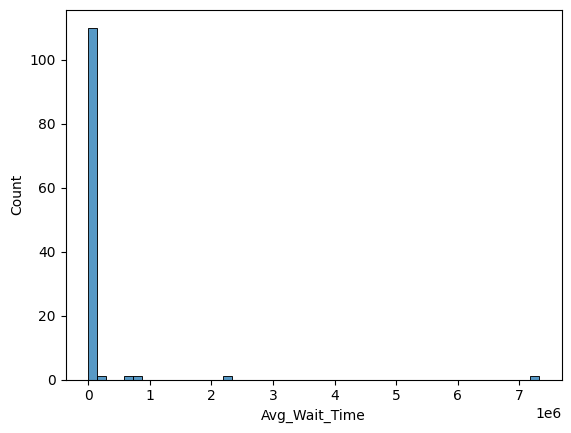

In [12]:
sns.histplot(x = 'Avg_Wait_Time', data=df_AverageWaitTimePerTask, bins=50)
plt.show()

Q3b) Max Wait time *per task*

In [13]:
df_MaxWaitTimePerTask = df2.groupby('xmlflow_status').max()

df_MaxWaitTimePerTask = df_MaxWaitTimePerTask['wait_time']
df_MaxWaitTimePerTask = df_MaxWaitTimePerTask.reset_index()
df_MaxWaitTimePerTask = df_MaxWaitTimePerTask.rename(columns={'wait_time': 'Max_wait_time'})

df_MaxWaitTimePerTask



,xmlflow_status,Max_wait_time
0,31115,38
1,31118,339
2,31119,3
3,31121,287
4,31122,48
...,...,...
110,31455,12
111,31457,20
112,31460,35
113,31463,13


Q3c) Average Processing Time *per task*

Q3c.1) First make a dataframe with the needed data:

In [14]:
df_processingTimes = df_StpFcEntries[['status_taken', 'proc_time', 'xmlflow_status']]
df_processingTimes = df_processingTimes[df_processingTimes['status_taken'].str.contains('Y')]
df_processingTimes = df_processingTimes[['xmlflow_status', 'proc_time']]
df_processingTimes

,xmlflow_status,proc_time
0,31314,6
1,31313,649
2,31313,6
3,31314,396
4,31188,11
...,...,...
35019,31200,2
35020,31205,40
35021,31210,68
35022,31436,1255


Q3c.2) Combine/Add the Processing times of entries under the same task.

In [15]:
# Add the processing times of the entries under the same task

# To calculate the average we need to know the number of entries per task.
# To do this create an extra column of 1s. This is done so that when rows with 
# the same task number are added together, the ones will be added together and we can see how many entries there were per task.

# Using DataFrame.insert() to add a column
df_processingTimes.insert(2, "Ones", np.ones(df_processingTimes.shape[0]), True)
print(df_processingTimes.head())

df_ProcTimePerTask = df_processingTimes.groupby('xmlflow_status').sum()
df_ProcTimePerTask = df_ProcTimePerTask.reset_index()
df_ProcTimePerTask

   xmlflow_status  proc_time  Ones
0           31314          6   1.0
1           31313        649   1.0
2           31313          6   1.0
3           31314        396   1.0
4           31188         11   1.0


,xmlflow_status,proc_time,Ones
0,31115,231,221.0
1,31118,2469,217.0
2,31119,135,4.0
3,31121,1591,124.0
4,31122,1588,221.0
...,...,...,...
110,31455,72,14.0
111,31457,681,34.0
112,31460,137,44.0
113,31463,586,44.0


Q3c.3) Calculate the Average proc time *per task*

In [16]:
df_AverageProcTimePerTask = df_ProcTimePerTask
df_AverageProcTimePerTask['avg_proc_time'] = df_AverageProcTimePerTask['proc_time']/df_AverageProcTimePerTask['Ones']
df_AverageProcTimePerTask

,xmlflow_status,proc_time,Ones,avg_proc_time
0,31115,231,221.0,1.045249
1,31118,2469,217.0,11.377880
2,31119,135,4.0,33.750000
3,31121,1591,124.0,12.830645
4,31122,1588,221.0,7.185520
...,...,...,...,...
110,31455,72,14.0,5.142857
111,31457,681,34.0,20.029412
112,31460,137,44.0,3.113636
113,31463,586,44.0,13.318182


Q3d) Processing Time Max

In [17]:
df_MaxProcTimePerTask = df_ProcTimePerTask[['xmlflow_status', 'proc_time']]
df_MaxProcTimePerTask = df_MaxProcTimePerTask.groupby('xmlflow_status').max()
df_MaxProcTimePerTask = df_MaxProcTimePerTask.rename(columns={'proc_time': 'max_proc_time'})
df_MaxProcTimePerTask = df_MaxProcTimePerTask.reset_index()

df_MaxProcTimePerTask

,xmlflow_status,max_proc_time
0,31115,231
1,31118,2469
2,31119,135
3,31121,1591
4,31122,1588
...,...,...
110,31455,72
111,31457,681
112,31460,137
113,31463,586


Q3e) Throughput (per second)

The Throughput(per second) per task was calculated by 1/the average processing time per task 

Frequency = 1/Period

Throughput = 1/Average proc time per task


In [18]:
df_ThroughputPerTask = 1/(df_AverageProcTimePerTask/1000)
df_ThroughputPerTask

,xmlflow_status,proc_time,Ones,avg_proc_time
0,0.032139,4.329004,4.524887,956.709957
1,0.032136,0.405022,4.608295,87.889834
2,0.032135,7.407407,250.000000,29.629630
3,0.032133,0.628536,8.064516,77.938404
4,0.032132,0.629723,4.524887,139.168766
...,...,...,...,...
110,0.031791,13.888889,71.428571,194.444444
111,0.031789,1.468429,29.411765,49.926579
112,0.031786,7.299270,22.727273,321.167883
113,0.031783,1.706485,22.727273,75.085324


Q3f) Throughput (per minute)

In [19]:
df_ThroughputPerTask_PerMinute = df_ThroughputPerTask*60
df_ThroughputPerTask_PerMinute


,xmlflow_status,proc_time,Ones,avg_proc_time
0,1.928330,259.740260,271.493213,57402.597403
1,1.928144,24.301337,276.497696,5273.390036
2,1.928083,444.444444,15000.000000,1777.777778
3,1.927959,37.712131,483.870968,4676.304211
4,1.927897,37.783375,271.493213,8350.125945
...,...,...,...,...
110,1.907487,833.333333,4285.714286,11666.666667
111,1.907366,88.105727,1764.705882,2995.594714
112,1.907184,437.956204,1363.636364,19270.072993
113,1.907002,102.389078,1363.636364,4505.119454


Q3g) Latency (per second)

Q3g.1) First make a dataframe with the needed data:

In [20]:
df_Throughput = df_StpFcEntries[['status_taken', 'xmlflow_status', 'wait_time', 'proc_time']]
df_Throughput = df_Throughput[df_Throughput['status_taken'].str.contains('Y')]
df_Throughput = df_Throughput[['xmlflow_status', 'wait_time', 'proc_time']]
df_Throughput

,xmlflow_status,wait_time,proc_time
0,31314,5,6
1,31313,4637,649
2,31313,1134,6
3,31314,41,396
4,31188,2,11
...,...,...,...
35019,31200,56,2
35020,31205,5,40
35021,31210,5,68
35022,31436,4,1255


Q3g.2) Combine/Add the Processing and Wait times of entries under the same task.

In [21]:
df_ProcAndWaitTimePerTask = df_Throughput.groupby('xmlflow_status').sum()
df_ProcAndWaitTimePerTask

,wait_time,proc_time
xmlflow_status,,
31115,513,231
31118,1024,2469
31119,9,135
31121,2032,1591
31122,566,1588
...,...,...
31455,44,72
31457,100,681
31460,255,137


Q3g.3) Latency (per second)

In [22]:
df_LatencyPerTask = df_ProcAndWaitTimePerTask['wait_time'] + df_ProcAndWaitTimePerTask['proc_time']
df_LatencyPerTask = df_LatencyPerTask.reset_index()
df_LatencyPerTask = df_LatencyPerTask.rename(columns = {0:'latency'})

df_LatencyPerTask['xmlflow_status'] = df_LatencyPerTask['xmlflow_status'].astype(str)
df_LatencyPerTask

,xmlflow_status,latency
0,31115,744
1,31118,3493
2,31119,144
3,31121,3623
4,31122,2154
...,...,...
110,31455,116
111,31457,781
112,31460,392
113,31463,690


##### Q4

Graphically show how many entries are waiting to be processed by each task in a bar chart. 



In [23]:
df3 = df_StpFcEntries[['xmlflow_status', 'status_taken']]
df3 = df3[df3['status_taken'].str.contains('N')]

df3.insert(2, "Ones", np.ones(df3.shape[0]), True)

print(df3)


df3 = df3.groupby('xmlflow_status').sum()
df3 = df3.drop('status_taken', axis=1)
df3 = df3.reset_index()

df3

       xmlflow_status status_taken  Ones
38              31199            N   1.0
123             31199            N   1.0
145             31199            N   1.0
148             31199            N   1.0
156             31199            N   1.0
...               ...          ...   ...
35002           31199            N   1.0
35003           31199            N   1.0
35006           31403            N   1.0
35024           31403            N   1.0
35025           31313            N   1.0

[1670 rows x 3 columns]


,xmlflow_status,Ones
0,31123,27.0
1,31199,1139.0
2,31221,140.0
3,31254,5.0
4,31284,11.0
5,31295,40.0
6,31313,1.0
7,31332,10.0
8,31333,5.0
9,31334,3.0


<Axes: xlabel='Ones', ylabel='xmlflow_status'>

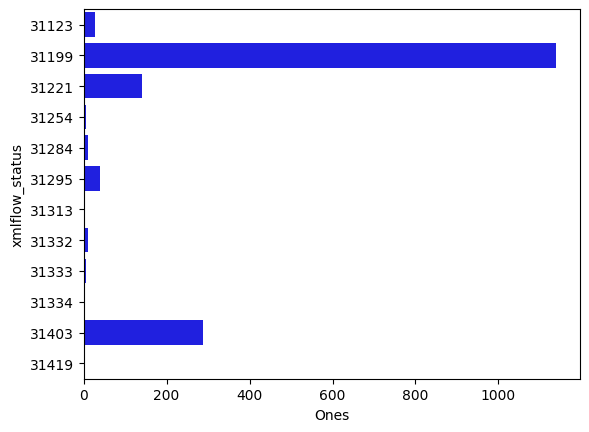

In [24]:
df3['xmlflow_status'] = df3['xmlflow_status'].astype(str)


# Plot entries waiting to be processed
sns.barplot(x='Ones', y='xmlflow_status', data=df3, color="b")

##### Q5

Graphically display the top five tasks in terms of processing time in a line graph for the last week. 



In [25]:
df4 = df_MaxProcTimePerTask
df4 = df4.sort_values('max_proc_time', ascending=False)

df4 = df4.head(5)

df4


,xmlflow_status,max_proc_time
63,31311,219238
22,31173,132321
64,31313,128476
36,31210,69495
17,31163,64949


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='xmlflow_status', ylabel='max_proc_time'>

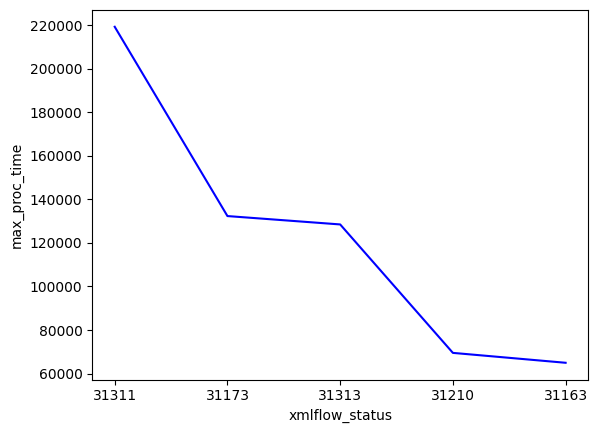

In [26]:
df4['xmlflow_status'] = df4['xmlflow_status'].astype(str)

sns.lineplot(y='max_proc_time', x='xmlflow_status', data=df4, color="b")

##### Q6

Write code to track the path of a contract in the workflow.



In [27]:
df5 = df_StpFcEntries[['ts_time_long', 'status_taken', 'fc_id', 'xmlflow_status', 'fc_cfamily', 'fc_cgroup', 'fc_ctype']]
df5 = df5[df5['status_taken'].str.contains('Y')]
df5 = df5.sort_values('fc_id')
df5 

,ts_time_long,status_taken,fc_id,xmlflow_status,fc_cfamily,fc_cgroup,fc_ctype
100,1684420000000,Y,17,31151,CURR,OPT,SMP
34,1684420000000,Y,17,31261,CURR,OPT,SMP
32,1684420000000,Y,17,31311,CURR,OPT,SMP
122,1684420000000,Y,17,31215,CURR,OPT,SMP
56,1684420000000,Y,17,31273,CURR,OPT,SMP
...,...,...,...,...,...,...,...
26791,1700830000000,Y,1781,31313,EQD,EQUIT,
26667,1704880000000,Y,1781,31311,EQD,EQUIT,
35022,1704880000000,Y,1781,31436,EQD,EQUIT,
35013,1704880000000,Y,1781,31185,EQD,EQUIT,


In [28]:
df_fc_id = pd.read_excel('Tech_Datasets2024\contractPaths.xlsx')
df_fc_id = df_fc_id['fc_id']


for i in df_fc_id:
    print("")
    selected_rows = df5.loc[df5['fc_id'] == i]
    selected_rows = selected_rows.sort_values('ts_time_long')
    selected_rows
    family = selected_rows.iloc[0]['fc_cfamily']
    group = selected_rows.iloc[0]['fc_cgroup']
    print("Contract", i, "|", family, "|", group, ":", end="")
    for j in selected_rows['xmlflow_status']:
        print(j, end="->")


Contract 1164 | COM | SPOT :31311->31273->31154->31210->31150->31261->31185->31188->31285->31215->31313->31436->31163->31200->31314->31181->31289->31205->31420->
Contract 121 | CURR | FXD :31289->31163->31138->31424->31205->31421->31436->31147->31118->31154->31181->31430->31126->31141->31200->31232->31215->31115->31399->31324->31144->31261->31391->31311->31328->31188->31314->31354->31313->31150->31185->31285->31122->31210->31273->31385->
Contract 1433 | CURR | OPT :31289->31314->31313->
Contract 65 | IRD | IRS :31311->31215->31285->31314->31313->31273->31185->31154->31261->31289->31157->31188->31181->31151->31163->
Contract 1699 | IRD | IRS :31288->31185->31188->31273->31311->31261->31289->31313->31151->31163->31314->31191->31154->31215->31307->31295->31157->31181->31285->31138->31313->31314->31123->31205->31421->31144->31147->31199->31430->31436->31424->31210->31200->31232->31303->31304->31277->31257->31301->31281->
Contract 1080 | SCF | SCF :31188->31154->31273->31150->31261->31285-

#### Q7) Data Analysis

Q7a.1) First make a dataframe with the needed data:

In [29]:
df6 = df_StpFcEntries[['status_taken', 'proc_time', 'xmlflow_status', 'fc_ctype']]
df6 = df6[df6['status_taken'].str.contains('Y')]
df6 = df6[['fc_ctype', 'proc_time']]
df6

,fc_ctype,proc_time
0,ASN,6
1,SMP,649
2,SMP,6
3,SMP,396
4,ASN,11
...,...,...
35019,,2
35020,,40
35021,,68
35022,,1255


Q7a.2) Calculate the mean proc time per group:

In [30]:
df6 = df6.groupby('fc_ctype').mean()
df6 = df6.reset_index()
df6


,fc_ctype,proc_time
0,,26.013350
1,ASI,7.500000
2,ASN,12.766667
3,BAR,118.765000
4,BAR2,9.466667
5,BSK,7.740741
6,CLR,5.642857
7,FWD,1120.071429
8,FXD,53.310727
9,LST,6.357143


In [31]:
df6 = df6.sort_values('proc_time', ascending=False)
df6

,fc_ctype,proc_time
7,FWD,1120.071429
16,SMPS,282.083333
3,BAR,118.765000
15,SMP,74.954700
8,FXD,53.310727
0,,26.013350
2,ASN,12.766667
4,BAR2,9.466667
13,REPO,8.113861
5,BSK,7.740741


C:\Users\AshishJakkam\AppData\Local\Temp\ipykernel_21500\1509225252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['fc_ctype'] = df6['fc_ctype'].astype(str)


<Axes: xlabel='fc_ctype', ylabel='proc_time'>

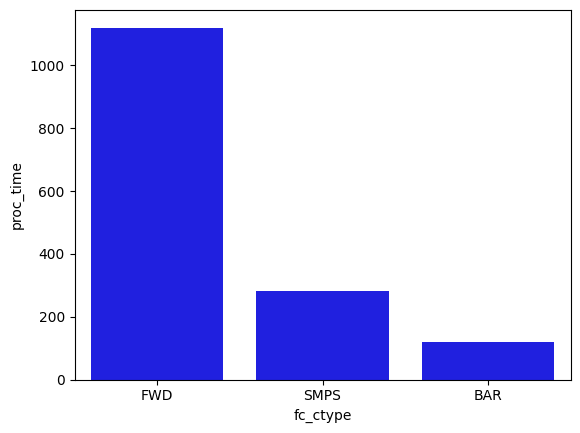

In [32]:
df6 = df6.head(3)
df6['fc_ctype'] = df6['fc_ctype'].astype(str)
df6

sns.barplot(y='proc_time', x='fc_ctype', data=df6, color="b")

Q7b) Are there any tasks with bottlenecks?

Yes as there are many entries with status_taken field as 'N'. This means that we need to count the number of 'N's per task to see the number of entries backlogged per task.
Assumption: The term "bottlenecks" refers to the amount of entries backlogged per task.

In [33]:
df7 = df_StpFcEntries[['xmlflow_status', 'status_taken']]
df7 = df7[df7['status_taken'].str.contains('N')]

# Using DataFrame.insert() to add a column
df7.insert(2, "Ones", np.ones(df7.shape[0]), True)

df7 = df7[['xmlflow_status', 'Ones']]

df7 = df7.groupby('xmlflow_status').sum()
df7 = df7.sort_values('Ones', ascending=False)

df7

,Ones
xmlflow_status,
31199,1139.0
31403,288.0
31221,140.0
31295,40.0
31123,27.0
31284,11.0
31332,10.0
31254,5.0
31333,5.0


<Axes: xlabel='xmlflow_status', ylabel='Ones'>

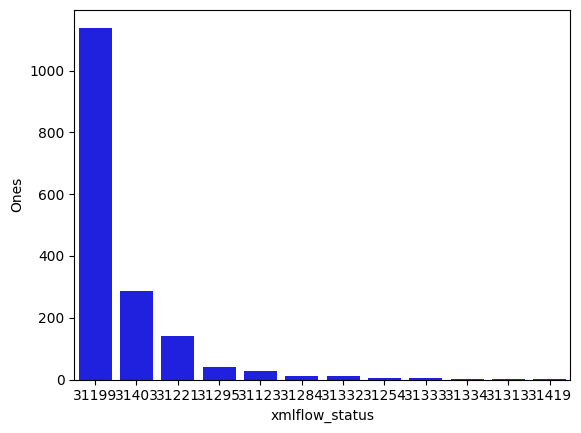

In [34]:
df7 = df7.reset_index()
df7['xmlflow_status'] = df7['xmlflow_status'].astype(str)
df7

sns.barplot(y='Ones', x='xmlflow_status', data=df7, color="b")

##### Q7c) Assume that the traders want to increase the volumes of FX Spot trades – the goals is to process 100 000 trades using a batch upload. 

Q7ci) Estimate how long it might take to process all the trades in the workflow? 

In [39]:
df8 = df_StpFcEntries[['proc_time', 'status_taken', 'fc_portfolio', 'fc_typology']]
df8 = df8[df8['status_taken'].str.contains('Y')]
df8 = df8[df8['fc_typology'].str.contains('Spot')]
# df8 = df8[df8['fc_portfolio'].str.contains('CM_FX_SPOT')]
df8

,proc_time,status_taken,fc_portfolio,fc_typology
937,4,Y,PC_TRAD_CE2,Spot
945,6,Y,PC_TRAD_CE2,Spot
950,5,Y,PC_TRAD_CE2,Spot
955,6,Y,PC_TRAD_CE,Spot
960,4,Y,PC_TRAD_CE2,Spot
...,...,...,...,...
34479,1,Y,CM_FX_SPOT,Spot
34480,1,Y,CM_FX_SPOT,Spot
34481,5,Y,CM_FX_SPOT,Spot
34487,5,Y,CM_FX_SPOT,Spot


In [40]:
df8 = df8[['proc_time']]
avgProcTime = df8.mean().values[0]
print("Average processing time = ", avgProcTime, "seconds")
print("Average processing time for 100000 trades = ", avgProcTime*1000, "seconds")

Average processing time =  24.404107320304735 seconds
Average processing time for 100000 trades =  24404.107320304734 seconds


Q7cii) Explain which predictive techniques you used to predict the total processing time and how you 
would implement this in theory. 

Q8 - SQL Code

In [ ]:
SELECT * FROM STPFC_ENTRY_TABLE

SELECT COUNT(*) FROM STPFC_ENTRY_TABLE

SELECT STATUS_TAKEN, FC_ID, FC_CFAMILY, FC_CGROUP, FC_CTYPE FROM STPFC_ENTRY_TABLE 

-- Q8a) Wait-time Average
--SELECT COUNT(*)
SELECT DISTINCT FC_ID, STATUS_TAKEN, FC_CFAMILY, FC_CGROUP, FC_CTYPE 
FROM STPFC_ENTRY_TABLE 
WHERE STATUS_TAKEN = 'Y'

-- Q8Bi) Processing Time Average
SELECT XMLFLOW_STATUS, AVG(PROC_TIME) AS 'Average Processing Time'
FROM  STPFC_ENTRY_TABLE 
WHERE STATUS_TAKEN = 'Y' AND WAIT_TIME != -1
GROUP BY XMLFLOW_STATUS

-- Q8bii) Processing Time Max
SELECT XMLFLOW_STATUS, MAX(PROC_TIME) AS 'Max Processing Time'
FROM  STPFC_ENTRY_TABLE 
WHERE STATUS_TAKEN = 'Y' AND WAIT_TIME != -1
GROUP BY XMLFLOW_STATUS

-- Q8biii) Processing Time Min
SELECT XMLFLOW_STATUS, MIN(PROC_TIME) AS 'Min Processing Time'
FROM  STPFC_ENTRY_TABLE 
WHERE STATUS_TAKEN = 'Y' AND WAIT_TIME != -1
GROUP BY XMLFLOW_STATUS


-- Q8biv) Throughput (per second)
SELECT XMLFLOW_STATUS, 1/(AVG(PROC_TIME)/1000) AS 'Throughput (per second)'
FROM  STPFC_ENTRY_TABLE 
WHERE STATUS_TAKEN = 'Y' AND WAIT_TIME != -1
GROUP BY XMLFLOW_STATUS


